# 自動特徴量選択による次元削減とSVMを用いたMNISTの分類

## はじめに
    MNISTという数字手書き文字のデータセットがある。このデータは28×28ピクセルの手書き数字の画像に対して、0から9までのラベルが振られたデータである。
    このレポートでは、10000枚の手書き数字の画像がそれぞれ0から9までのどの数字にあたるかを識別する、SVMを用いたモデルの生成、および生成モデルを用いた推論を実装する。また、性能向上のために用いた交差検証、グリッドサーチ、および自動特徴量選択についても記載する。

## レポートの構成について
    実行したコードの記載されたセルの次のセルにコードの内容、使用した手法などの説明を記載する形になっている。

In [1]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

DATAPATH = "data/digits.csv"
df = pd.read_csv(DATAPATH)
X = df.drop("label",axis=1).values
y = df["label"].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

C:\Users\usami\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## データセットの用意
    ここでcsvからデータをロードし、画像データ、ラベルデータをそれぞれトレイン用のデータ、テスト用のデータに分割する。トレイン用のデータとテスト用のデータを分けることにより、生成したモデルの性能評価を行うことができる。
    また、ここではデータ分割にtrain_test_splitというランダムにトレインデータとテストデータを分割する関数を使用しているが、random_stateパラメータを任意に設定することで毎回同じ出力が発生するようにしてある。

In [2]:
pipe = Pipeline([("scaler", MinMaxScaler()),("svm",svm.SVC())])
pipe_grid = Pipeline([("scaler", MinMaxScaler()),("svm",svm.SVC())])
selecter_pipe = Pipeline([("scaler", MinMaxScaler()),
                         ("select",SelectFromModel(RFC(n_estimators=100,random_state=42),
                                                   threshold="median"))])

## モデルの設定
    ここではpipelineクラスを用いてモデルの設定を行う。pipelineを用いると、様々な処理に対するコード量を減らし、シンプルに記載することができる。また、pipeline内で設定されている各種パラメータの説明を以下で行う。

### 前処理
    各pipelineではトレインデータに対してMinMaxScaler関数を用いて標準化を行っている。これはデータの特徴量の値を一定の範囲に収める変換であり、本データでは[0,255]→[0,1]になるよう変換される。
    標準化のような特徴のスケール変換は機械学習においてデータの前処理によく使用されるが、これはスケールを行うことによって、学習時のパラメータ更新がパラメータごとに偏ることがなくなり、最適解を見つけるまでのステップが少なくなるというメリットがあるからである。

### サポートベクターマシン
    本レポートにおける分類モデルのアルゴリズムにはサポートベクターマシンを使用している。
    サポートベクターマシンとは、線形識別機における重みベクトル、バイアスなどのパラメータ設定をマージン最大化の考えを以て定めるというものである。
    マージンとはデータ分類の決定境界と、各クラスのデータ点の最短距離を指す。つまり、求める決定境界が各クラスのデータからなるべく離れたこところに設定するというのがマージン最大化の考え方である。

<img src="./images/margin_img.png">

    例えば上図の左右の絵を比べてみると、右の絵の方が直線と各クラスの最短の点との距離が左の絵よりも長くなっている。この距離がマージンであり、このマージンを最大化するように境界を求めるというのがサポートベクターマシンの考え方である。

### 自動特徴量選択
    3つ目のpipelineのselecter_pipeにおいては、特徴量選択にSelectFromModel関数を使用している。この関数はモデルベース特徴量選択という手法を実現するものであり、この手法は教師あり学習モデルを用いて個々の特徴量の重要性を判断し、重要なものだけを残すという手法である。特徴量選択を行うことで、モデルが単純化し汎化性能が向上したり、次元削減となって計算時間の短縮につながったりすることが期待される。
    特にモデルベース特徴量選択には特徴量の重要性の指標が出力されるようなモデルを使用しなければ特徴量を選択することができない。そこで今回はモデルとしてランダムフォレストを使用した。ランダムフォレストはfeature_impotances_属性を持ち、これは特徴量の重要性そのものをエンコードしてあるため、特徴量選択の指標として使用することができる。また本レポートでは選択時の閾値として中央値を使用した。

In [3]:
def fit_model_CV(X_train,X_test,y_train,y_test,pipe,parameters):
        
        clf = GridSearchCV(pipe, param_grid=parameters,verbose=2,cv=2,
                           n_jobs=-1,return_train_score=False)
        clf.fit(X_train,y_train)
        print("Best cv accuracy:{:.2f}".format(clf.best_score_))
        print("Test set score: {:.2f}".format(clf.score(X_test,y_test)))
        print("Best parameters:{}".format(clf.best_params_))
        return clf

## 交差検証を用いたグリッドサーチ
    ここでは交差検証を用いたグリッドサーチを行う関数を作成している。まず交差検証とグリッドサーチについて説明する。
### 交差検証
    交差検証とは汎化性能を評価する統計的手法である。トレインデータとテストデータの分割を一度だけではなく複数行い、複数の分割方法でそれぞれモデルを訓練する。例えば一度の分割によってクラス分類が難しいデータばかりトレインデータになり、テストデータが簡単なデータばかりになってしまうと、異常に高い精度を得ることとなってしまう。交差検証を行うことで、個々のサンプルがいずれかの分割に含まれている上に、全てのデータが一度だけテストに用いられているので、全てのデータが一度だけテストに用いられることになる。よって、モデルが全サンプルに対して高い汎化性能を持たなければ、交差検証スコアと平均を高くできない。逆に言うと、スコアと平均を見ることにより、訓練したモデルの汎化性能を評価できる。
### グリッドサーチ
    機械学習で用いられるモデルには様々なパラメータが設定されている。本レポートで使用するサポートベクターマシンにおいても、正則化項、カーネルの種類、カーネルの幅など様々に設定可能なパラメータを持つ。このパラメータを調整することによってモデルの性能を向上させることができる。あらかじめ複数のパラメータを用意し、それら全ての組み合わせに対して訓練を行い、性能を確認する手法をグリッドサーチという。ScikitLearnにはGridsearchCVという交差検証を行いながらグリッドサーチを行う関数が用意されており、今回はこれを用いる。
    ただしグリッドサーチには計算時間が増大するというデメリットもある。3×3のパラメータを用意し、かつ3分割交差検証を行うとすると、計27回の訓練を行わなくてはならない。

In [4]:
parameters = [
            {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['linear']},
            {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['rbf'], 'svm__gamma': [0.001, 0.0001]},
            {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['poly'], 'svm__degree': [2, 3, 4], 'svm__gamma': [0.001, 0.0001]},
            {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['sigmoid'], 'svm__gamma': [0.001, 0.0001]}
            ]
clf_cv = fit_model_CV(X_train,X_test,y_train,y_test,pipe_grid,parameters)

Fitting 2 folds for each of 44 candidates, totalling 88 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed: 20.2min finished
C:\Users\usami\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Best cv accuracy:0.95
Test set score: 0.96
Best parameters:{'svm__C': 1000, 'svm__degree': 2, 'svm__gamma': 0.001, 'svm__kernel': 'poly'}


In [5]:
pipe_val = Pipeline([("scalar", MinMaxScaler()),
                     ("svm",svm.SVC(C=1000,kernel="poly",degree=2,gamma=0.001))])
print(cross_val_score(pipe_val,X,y,cv=5,verbose=2,n_jobs=-1))

[0.96205691 0.95802099 0.9645     0.95397699 0.95743615]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


In [26]:
cv_result_df = pd.DataFrame(clf_cv.cv_results_)
pd.set_option('display.max_colwidth',100)
maxidx = cv_result_df["mean_test_score"].idxmax()
minidx = cv_result_df["mean_test_score"].idxmin()
print(cv_result_df.loc[maxidx,["params","mean_test_score"]])
print(cv_result_df.loc[minidx,["params","mean_test_score"]])

params             {'svm__C': 1000, 'svm__degree': 2, 'svm__gamma': 0.001, 'svm__kernel': 'poly'}
mean_test_score                                                                           0.94725
Name: 30, dtype: object
params             {'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.0001, 'svm__kernel': 'poly'}
mean_test_score                                                                         0.10925
Name: 13, dtype: object


## グリッドサーチの実行
### グリッドサーチの内容について
    ここで設定したパラメータの組み合わせに対して交差検証を用いたグリッドサーチを行う。44のパラメータ組み合わせに対して2分割交差検証を行っているので、計88回の訓練が行われる。2分割交差検証は交差検証の分割数としては少なく、精度が低下する可能性があるが、グリッドサーチにおいては各パラメータの大小を比較するのが大目的なので大きな問題はない。
### 実行結果
    グリッドサーチの結果、与えたパラメータの中ではC=1000,kernel="poly",degree=2,gamma=0.001の組み合わせが最もよく、テストデータに対して96%の正答率を返した。ただし2分割交差検証は分割数として少ないので、再度5分割交差検証を行って交差検証を行っている。こちらもおおよそ96%程度の正答率を返しており、高精度かつ汎化性能の高いモデルを構築できたと言える。
    またグリッドサーチを行った全てのパラメータの内、平均テストスコアが最大のものと最小のものを比較してみる。最大のスコアは0.95,最小は0.11となっており、パラメータ調整によって性能が大きく変化することが見て取れ、パラメータ調整の重要性、およびグリッドサーチの有用性を示す結果となった。

In [44]:
X_train_l1 = selecter_pipe.fit_transform(X_train,y_train)
X_test_l1 = selecter_pipe.transform(X_test)
print(X_train_l1.shape)

C:\Users\usami\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(8000, 392)


In [38]:
parameters2 = [
            {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
            {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]},
            {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001]},
            {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}
            ]
clf_l1 = GridSearchCV(svm.SVC(), param_grid=parameters2,verbose=2,cv=2,
                           n_jobs=-1,return_train_score=False)
clf_l1.fit(X_train_l1,y_train)
print("Best cv accuracy:{:.2f}".format(clf_l1.best_score_))
print("Test set score: {:.2f}".format(clf_l1.score(X_test_l1,y_test)))
print("Best parameters:{}".format(clf_l1.best_params_))

Fitting 2 folds for each of 44 candidates, totalling 88 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed: 10.4min finished


Best cv accuracy:0.95
Test set score: 0.96
Best parameters:{'C': 1000, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}


In [39]:
print(cross_val_score(pipe_val,X_train_l1,y_train,cv=5,verbose=2,n_jobs=-1))

[0.96137072 0.96004994 0.95121951 0.95619524 0.95300752]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.4s finished


In [41]:
y_pred = clf_l1.predict(X_test_l1)
print(clf_l1.score(X_test_l1,y_test))
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred, labels=range(10)))

0.9585
             precision    recall  f1-score   support

          0       0.95      1.00      0.97       204
          1       0.97      0.99      0.98       221
          2       0.96      0.93      0.94       173
          3       0.97      0.94      0.96       218
          4       0.96      0.98      0.97       197
          5       0.95      0.96      0.95       183
          6       0.96      0.98      0.97       202
          7       0.97      0.97      0.97       223
          8       0.93      0.90      0.91       183
          9       0.95      0.93      0.94       196

avg / total       0.96      0.96      0.96      2000

[[203   0   0   0   0   0   1   0   0   0]
 [  0 219   0   1   0   0   1   0   0   0]
 [  2   1 161   0   3   0   0   3   3   0]
 [  0   0   3 205   0   1   3   0   3   3]
 [  0   0   0   0 193   0   0   0   0   4]
 [  2   1   0   0   0 175   2   0   3   0]
 [  2   0   1   0   0   1 197   0   1   0]
 [  0   2   1   0   0   1   0 217   0   2]
 [  1   2 

In [42]:
wrong_prediction = []
wrong_X = []
wrong_y
for counter,i in enumerate(y_test):
    if y_test[counter] == 8:
        if y_pred[counter]!=i:
            keep_list = [counter,y_pred[counter]]
            wrong_prediction.append(keep_list)
            wrong_X.append(X_)
print(wrong_prediction)

[[111, 1], [142, 2], [177, 3], [277, 5], [416, 5], [461, 7], [533, 1], [718, 9], [758, 5], [804, 3], [980, 3], [1132, 3], [1147, 5], [1152, 5], [1235, 6], [1469, 4], [1501, 2], [1608, 3], [1988, 0]]


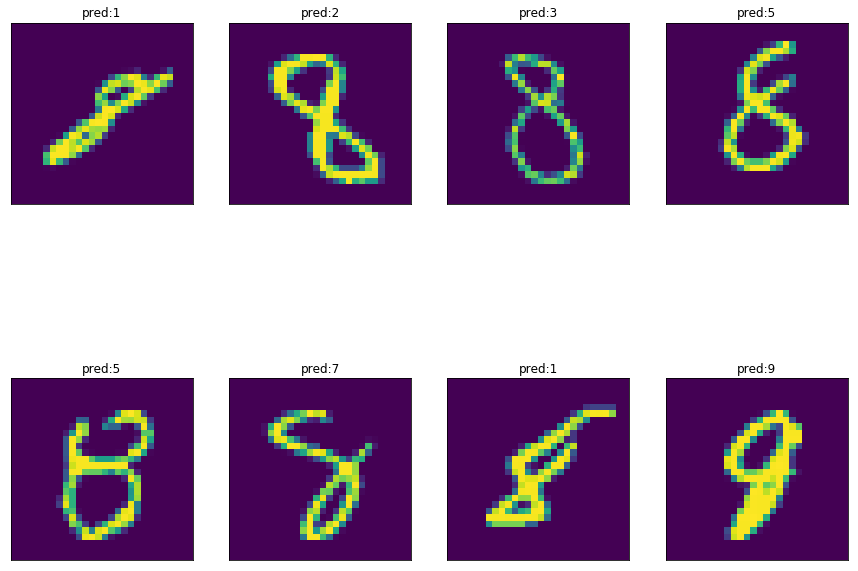

In [43]:
image_shape = [28,28]
fix, axes = plt.subplots(2,4,figsize=(15,12),
                        subplot_kw={"xticks":(),"yticks":()})
for i,ax in zip(wrong_prediction,axes.ravel()):
    ax.imshow(X_test[i[0]].reshape(image_shape))
    ax.set_title("pred:{}".format(i[1]))

In [ ]:
selecter_pipe.

In [ ]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.5):

    # setup marker generator and color map
    colors = ("red","blue","orange","cyan","green",
          "gray", "pink","yellow","brown","black")
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                     label=cl)

In [19]:
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print(pipe.score(X_test,y_test))
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred, labels=range(10)))

C:\Users\usami\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.9575
             precision    recall  f1-score   support

          0       0.98      0.99      0.98       216
          1       0.96      0.98      0.97       195
          2       0.96      0.96      0.96       198
          3       0.96      0.94      0.95       202
          4       0.95      0.95      0.95       200
          5       0.94      0.98      0.96       182
          6       1.00      0.96      0.98       218
          7       0.97      0.92      0.94       209
          8       0.92      0.94      0.93       196
          9       0.94      0.95      0.95       184

avg / total       0.96      0.96      0.96      2000

[[214   0   0   0   0   1   0   0   0   1]
 [  0 192   1   1   0   0   0   1   0   0]
 [  0   0 190   2   2   0   0   1   3   0]
 [  0   2   0 189   0   2   0   0   8   1]
 [  1   1   0   0 191   2   0   0   1   4]
 [  0   2   1   1   0 178   0   0   0   0]
 [  1   1   1   0   0   2 210   0   3   0]
 [  1   2   4   0   4   1   0 192   1   4]
 [  2   1 

In [21]:
wrong_prediction_8_l1 = []
for counter,i in enumerate(y_test):
    if y_test[counter] == 8:
        if y_pred[counter]!=i:
            keep_list = [counter,y_pred[counter]]
            wrong_prediction_8_l1.append(keep_list)
print(wrong_prediction_8_l1)

[[103, 5], [337, 5], [758, 0], [1264, 4], [1374, 0], [1444, 3], [1478, 3], [1513, 4], [1552, 9], [1565, 5], [1716, 1], [1839, 5]]


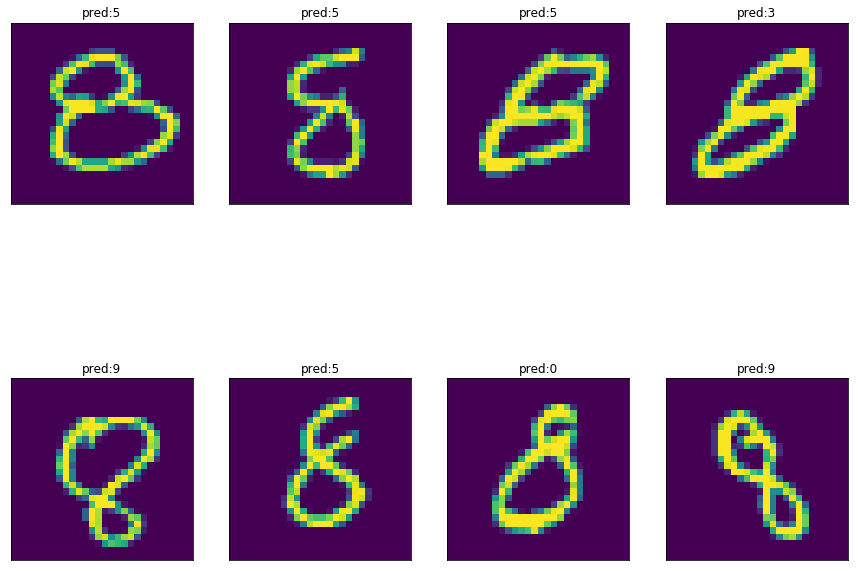

In [22]:
fix, axes = plt.subplots(2,4,figsize=(15,12),
                        subplot_kw={"xticks":(),"yticks":()})
for i,ax in zip(wrong_prediction,axes.ravel()):
    ax.imshow(X_test[i[0]].reshape(image_shape))
    ax.set_title("pred:{}".format(i[1]))